# Tutorial-08 Variational Quantum Classifier
- Step 1: Prepare training data and perform data preprocessing
- Step 2: Construct encoding circuit
- Step 3: Construct variational circuit
- Step 4: Build the VQC model with the encoding circuit as input layer, variational circuit as pqc layer and an output layer with a custom activation function
- Step 5: Decide on the optimizer, the loss function, the evaluation metrics and callbacks for training
- Step 6: Train the classifier
- Step 7: Evaluate the result

### Install dependencies

In [1]:
if 'google.colab' in str(get_ipython()):
  # install packages needed for this task
  !pip install tensorflow==2.3.1
  !pip install tensorflow_quantum==0.4.0
  !pip install quple==0.7.8

In [1]:
import tensorflow_quantum as tfq
import tensorflow as tf
import quple
import cirq

 ## Step 1: Prepare Training Data and Perform Data Preprocessing

In [2]:
# download training data (hmumu 2jet)
!wget https://gitlab.cern.ch/clcheng/gsoc2021_qml/-/raw/master/data/hmumu_twojet_0719.npy

--2021-03-29 21:44:32--  https://gitlab.cern.ch/clcheng/gsoc2021_qml/-/raw/master/data/hmumu_twojet_0719.npy
Resolving gitlab.cern.ch (gitlab.cern.ch)... 2001:1458:201:e3::100:423, 2001:1458:d00:7::100:7, 2001:1458:d00:32::100:22, ...
Connecting to gitlab.cern.ch (gitlab.cern.ch)|2001:1458:201:e3::100:423|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2032704 (1.9M) [application/octet-stream]
Saving to: ‘hmumu_twojet_0719.npy’

100%[======================================>] 2,032,704   --.-K/s   in 0.04s   

2021-03-29 21:44:32 (52.9 MB/s) - ‘hmumu_twojet_0719.npy’ saved [2032704/2032704]



In [2]:
import numpy as np
# prepare training data
data = np.load('hmumu_twojet_0719.npy')
x = data[:,:-1]
y = data[:,-1]
print('x: shape = {}'.format(x.shape))
print(x)
print('y: shape = {}'.format(y.shape))
print(y)

x: shape = (18148, 13)
[[ 1.35123826e+02  9.97897017e-01  9.58638570e-01 ...  4.58769383e-01
  -3.05654504e+00  1.80854129e+03]
 [ 2.43290406e+02  3.03747750e-01  6.74568519e-01 ... -1.34468994e+00
  -2.72506172e+00  5.11933555e+02]
 [ 1.64464537e+02 -5.81922591e-02  5.42151745e-02 ... -6.23148328e-01
   3.07514485e+00  3.44958465e+02]
 ...
 [ 2.16542712e+01 -3.05524425e+00  4.59151309e-01 ...  9.26630829e-01
   3.08020790e+00  5.62347204e+02]
 [ 4.19387585e+01  1.89239955e+00  4.48033832e-01 ...  1.73410377e+00
  -2.62992120e+00  1.44320990e+02]
 [ 9.33202609e+01  8.70685882e-01  8.74988118e-01 ... -1.21892943e+00
   2.85587492e+00  2.03240716e+02]]
y: shape = (18148,)
[1. 1. 1. ... 0. 0. 0.]


In [3]:
# let's say we want to train on a circuit with 5 qubit
n_qubit = 5
# let's say we want to train on 1000 events
n_event = 1000

In [4]:
# prepare data preprocessors from sklearn
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
# we apply 3 data preprocessors
# 1. PCA to reduce the dimension to 5 to fit the 5 qubit circuit
# 2. StandardScaler to standardize features by removing the mean and scaling to unit variance
# 3. MinMaxScaler to bound the data in the range [-1,+1]
preprocessors = [PCA(n_components=n_qubit, random_state=3), StandardScaler(), MinMaxScaler((-1,1))]

In [5]:
from quple.components.data_preparation import prepare_train_val_test
# split the data into training set, validation set and test set
x_train, x_val, x_test, y_train, y_val, y_test = prepare_train_val_test(x, y, train_size=n_event, val_size=n_event, test_size=n_event, preprocessors=preprocessors, random_state=24)
print('x_train: shape = {}'.format(x_train.shape))
print('x_val: shape = {}'.format(x_val.shape))
print('x_test: shape = {}'.format(x_test.shape))
print('y_train: shape = {}'.format(y_train.shape))
print('y_val: shape = {}'.format(y_val.shape))
print('y_test: shape = {}'.format(y_test.shape))

x_train: shape = (1000, 5)
x_val: shape = (1000, 5)
x_test: shape = (1000, 5)
y_train: shape = (1000,)
y_val: shape = (1000,)
y_test: shape = (1000,)


## Step 2: Construct Encoding Circuit

In [6]:
from quple.data_encoding import FirstOrderPauliZEncoding, SecondOrderPauliZEncoding
from quple.data_encoding.encoding_maps import self_product, cosine_product, modified_cosine_product, distance_measure, arithmetic_mean, polynomial

In [7]:
# let's try the first order pauli z encoding circuit with depth 2
encoding_circuit = FirstOrderPauliZEncoding(feature_dimension=n_qubit, copies=2)
# Notice that there is a default scale factor of pi added to the encoding function 
# since we assume the input is in the range [-1, +1]. You can override this behavior
# by passing the argument parameter_scale=1 to the initializer
encoding_circuit

(0, 0): ───H───Rz(pi*x_0)───H───Rz(pi*x_0)───

(0, 1): ───H───Rz(pi*x_1)───H───Rz(pi*x_1)───

(0, 2): ───H───Rz(pi*x_2)───H───Rz(pi*x_2)───

(0, 3): ───H───Rz(pi*x_3)───H───Rz(pi*x_3)───

(0, 4): ───H───Rz(pi*x_4)───H───Rz(pi*x_4)───

## Step 3: Construct Variational Circuit

In [8]:
from quple.circuits.variational_circuits import EfficientSU2

In [9]:
# let's try the Efficient SU2 variational circuit with depth 2
variational_circuit = EfficientSU2(n_qubit=n_qubit, copies=2)
#The readout qubit will be entangled to all input qubits via certain two qubit gate operations
variational_circuit.add_readout('XX')
variational_circuit

┌──┐       ┌──┐                                                ┌──┐       ┌──┐
(-1, -1): ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────XX──────────XX──────────XX──────────XX──────────XX──────────
                                                                                                                                                        │           │           │           │           │
(0, 0): ─────Ry(θ_0)───Rz(θ_5)───@───@───@────@────────────────────Ry(θ_10)───Rz(θ_15)───@──────────@───@────@────────────────────Ry(θ_20)───Rz(θ_25)───XX^(θ_30)───┼───────────┼───────────┼───────────┼───────────
                                 │   │   │    │                                          │          │   │    │                                                      │           │           │           │
(0, 1): ─────Ry(θ_1)───Rz(θ_6)───X───┼───┼────┼@────@────@─────────Ry(θ_11)───Rz(θ_16)───X──────────┼───┼────┼@────@────@─────────Ry(θ_21)───Rz(θ_26)───────────────XX^(θ_31)───┼───────────┼───────────┼───────────
                                     │   │    ││    │    │                                          │   │    ││    │    │                                                       │           │           │
(0, 2): ─────Ry(θ_2)───Rz(θ_7)───────X───┼────┼X────┼────┼@────@───Ry(θ_12)───Rz(θ_17)──────────────X───┼────┼X────┼────┼@────@───Ry(θ_22)───Rz(θ_27)───────────────────────────XX^(θ_32)───┼───────────┼───────────
                                         │    │     │    ││    │                                        │    │     │    ││    │                                                             │           │
(0, 3): ─────Ry(θ_3)───Rz(θ_8)───────────X────┼─────X────┼X────┼───@──────────Ry(θ_13)───Rz(θ_18)───────X────┼─────X────┼X────┼───@──────────Ry(θ_23)───Rz(θ_28)────────────────────────────XX^(θ_33)───┼───────────
                                              │          │     │   │                                         │          │     │   │                                                                     │
(0, 4): ─────Ry(θ_4)───Rz(θ_9)────────────────X──────────X─────X───X──────────Ry(θ_14)───Rz(θ_19)────────────X──────────X─────X───X──────────Ry(θ_24)───Rz(θ_29)────────────────────────────────────────XX^(θ_34)───
                                             └──┘       └──┘                                                └──┘       └──┘

In [10]:
print('Readout qubit:')
print(variational_circuit.readout_qubit)

Readout qubit:
(-1, -1)


## Step 4 and 5: Build the VQC Model

In [11]:
from quple.classifiers import VQC
# let's use the following settings
# output layer activation = sigmoid
# optimizer = Adam
# metrics = binary accuracy and auc
# loss = mean squared loss

# construct the vqc model
vqc = VQC(encoding_circuit, variational_circuit,
          activation='sigmoid',
          optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
          metrics=['binary_accuracy','qAUC'],
          readout=[cirq.Z(variational_circuit.readout_qubit)],
          loss='mse',
          random_state=16)

Registered encoding circuit with feature dimension: 5
Registered variational circuit with number of parameters: 35


## Step 6: Train the Classifier

In [12]:
# train the vqc model
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)
vqc.fit(x_train, y_train,
        batch_size=64,
        epochs=10,
        verbose=1,
        validation_data=(x_val, y_val),
        callbacks=[callback])

Converting circuits to tensors...
Converting circuits to tensors...


Epoch 1/10
16/16 [==============================] - 5s 338ms/step - loss: 0.3208 - binary_accuracy: 0.4950 - q_auc: 0.4627 - val_loss: 0.2617 - val_binary_accuracy: 0.5530 - val_q_auc: 0.5720
Epoch 2/10
16/16 [==============================] - 8s 505ms/step - loss: 0.2625 - binary_accuracy: 0.5460 - q_auc: 0.5457 - val_loss: 0.2313 - val_binary_accuracy: 0.6640 - val_q_auc: 0.6929
Epoch 3/10
16/16 [==============================] - 7s 460ms/step - loss: 0.2345 - binary_accuracy: 0.6490 - q_auc: 0.6776 - val_loss: 0.2130 - val_binary_accuracy: 0.7050 - val_q_auc: 0.7804
Epoch 4/10
16/16 [==============================] - 6s 390ms/step - loss: 0.2154 - binary_accuracy: 0.6940 - q_auc: 0.7565 - val_loss: 0.2005 - val_binary_accuracy: 0.7670 - val_q_auc: 0.8242
Epoch 5/10
16/16 [==============================] - 7s 455ms/step - loss: 0.1991 - binary_accuracy: 0.7310 - q_auc: 0.8035 - val_loss: 0.1895 - val_binary_accuracy: 0.7280 - val_q_auc: 0.8433
Epoch 6/10
16/16 [======================

## Step 7: Evaluate the Result

In [14]:
# test the model
y_score = vqc.predict(x_test)
y_score

Converting circuits to tensors...


array([[0.25551227],
       [0.6398538 ],
       [0.41366413],
       [0.2645321 ],
       [0.49183375],
       [0.2348527 ],
       [0.73499197],
       [0.79073775],
       [0.66524744],
       [0.30033818],
       [0.22771408],
       [0.23009828],
       [0.6060846 ],
       [0.22311276],
       [0.25311056],
       [0.47869644],
       [0.28882018],
       [0.32856247],
       [0.34647343],
       [0.5463049 ],
       [0.24785633],
       [0.25187436],
       [0.6795101 ],
       [0.30801257],
       [0.6309264 ],
       [0.6832956 ],
       [0.2519198 ],
       [0.29563224],
       [0.21535556],
       [0.46819228],
       [0.85252976],
       [0.44572625],
       [0.22500664],
       [0.5449805 ],
       [0.27084538],
       [0.26665738],
       [0.6666252 ],
       [0.3977476 ],
       [0.54083663],
       [0.7263422 ],
       [0.3182606 ],
       [0.72660613],
       [0.22287227],
       [0.31592584],
       [0.7518665 ],
       [0.22200659],
       [0.22973558],
       [0.829

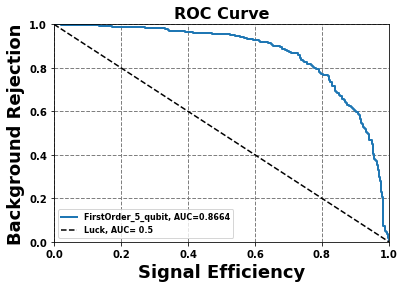

In [15]:
# plot a roc curve
from sklearn.metrics import roc_curve, auc
fpr, tpr, _ = roc_curve(y_test, y_score)
plt = quple.utils.utils.plot_roc_curve(fpr, tpr, label='FirstOrder_5_qubit', title='ROC Curve')

## Try Different Encoding Circuits

In [17]:
# Try out different encoding maps and using SecondOrderExpansion encoding circuit
# encoding map = self_product ~ x_0*x_1*x_2...
second_order_self_product = SecondOrderPauliZEncoding(feature_dimension=n_qubit, entangle_strategy='linear')
second_order_self_product

(0, 0): ───H───Rz(pi*x_0)───@──────────────────────@────────────────────────────────────────────────────────────────────────────────H───Rz(pi*x_0)───@───────────────────────────────@────────────────────────────────────────────────────────────────────────────────────
                            │                      │                                                                                                 │                               │
(0, 1): ───H───Rz(pi*x_1)───X───Rz(pi*<x_0*x_1>)───X───@──────────────────────@─────────────────────────────────────────────────────H───Rz(pi*x_1)───X────────────Rz(pi*<x_0*x_1>)───X───@──────────────────────@─────────────────────────────────────────────────────────
                                                       │                      │                                                                                                          │                      │
(0, 2): ───H───Rz(pi*x_2)──────────────────────────────X───Rz(pi*<x_1*x_2>)───X───@──────────────────────@──────────────────────────H───Rz(pi*x_2)───────────────────────────────────────X───Rz(pi*<x_1*x_2>)───X───@──────────────────────@──────────────────────────────
                                                                                  │                      │                                                                                                          │                      │
(0, 3): ───H───Rz(pi*x_3)─────────────────────────────────────────────────────────X───Rz(pi*<x_2*x_3>)───X───@──────────────────────@───H────────────Rz(pi*x_3)─────────────────────────────────────────────────────X───Rz(pi*<x_2*x_3>)───X───@──────────────────────@───
                                                                                                             │                      │                                                                                                          │                      │
(0, 4): ───H───Rz(pi*x_4)────────────────────────────────────────────────────────────────────────────────────X───Rz(pi*<x_3*x_4>)───X───H────────────Rz(pi*x_4)────────────────────────────────────────────────────────────────────────────────X───Rz(pi*<x_3*x_4>)───X───

In [18]:
# encoding map = cosine_product ~ cos(x_0)*cos(x_1)*...
second_order_cosine_product = SecondOrderPauliZEncoding(feature_dimension=n_qubit, encoding_map=cosine_product, entangle_strategy='linear')
second_order_cosine_product

(0, 0): ───H───Rz(pi*x_0)───@────────────────────────────────@──────────────────────────────────────────────────────────────────────────────────────────────────────────────H───Rz(pi*x_0)───@─────────────────────────────────────────@──────────────────────────────────────────────────────────────────────────────────────────────────────────────────
                            │                                │                                                                                                                               │                                         │
(0, 1): ───H───Rz(pi*x_1)───X───Rz(pi*<cos(x_0)*cos(x_1)>)───X───@────────────────────────────────@─────────────────────────────────────────────────────────────────────────H───Rz(pi*x_1)───X────────────Rz(pi*<cos(x_0)*cos(x_1)>)───X───@────────────────────────────────@─────────────────────────────────────────────────────────────────────────────
                                                                 │                                │                                                                                                                                        │                                │
(0, 2): ───H───Rz(pi*x_2)────────────────────────────────────────X───Rz(pi*<cos(x_1)*cos(x_2)>)───X───@────────────────────────────────@────────────────────────────────────H───Rz(pi*x_2)─────────────────────────────────────────────────X───Rz(pi*<cos(x_1)*cos(x_2)>)───X───@────────────────────────────────@────────────────────────────────────────
                                                                                                      │                                │                                                                                                                                        │                                │
(0, 3): ───H───Rz(pi*x_3)─────────────────────────────────────────────────────────────────────────────X───Rz(pi*<cos(x_2)*cos(x_3)>)───X───@────────────────────────────────@───H────────────Rz(pi*x_3)─────────────────────────────────────────────────────────────────────────X───Rz(pi*<cos(x_2)*cos(x_3)>)───X───@────────────────────────────────@───
                                                                                                                                           │                                │                                                                                                                                        │                                │
(0, 4): ───H───Rz(pi*x_4)──────────────────────────────────────────────────────────────────────────────────────────────────────────────────X───Rz(pi*<cos(x_3)*cos(x_4)>)───X───H────────────Rz(pi*x_4)──────────────────────────────────────────────────────────────────────────────────────────────────────────────X───Rz(pi*<cos(x_3)*cos(x_4)>)───X───

In [19]:
# encoding map = distance_measure ~ (x_0-x_1)*(x_1-x_2)*(x_2-x_3)/2**(number of pairs)...
second_order_distance_measure = SecondOrderPauliZEncoding(feature_dimension=n_qubit, encoding_map=distance_measure, entangle_strategy='linear')
second_order_distance_measure

(0, 0): ───H───Rz(pi*x_0)───@────────────────────────────@──────────────────────────────────────────────────────────────────────────────────────────────────H───Rz(pi*x_0)───@─────────────────────────────────────@──────────────────────────────────────────────────────────────────────────────────────────────────────
                            │                            │                                                                                                                   │                                     │
(0, 1): ───H───Rz(pi*x_1)───X───Rz(pi*<x_0/2 - x_1/2>)───X───@────────────────────────────@─────────────────────────────────────────────────────────────────H───Rz(pi*x_1)───X────────────Rz(pi*<x_0/2 - x_1/2>)───X───@────────────────────────────@─────────────────────────────────────────────────────────────────────
                                                             │                            │                                                                                                                            │                            │
(0, 2): ───H───Rz(pi*x_2)────────────────────────────────────X───Rz(pi*<x_1/2 - x_2/2>)───X───@────────────────────────────@────────────────────────────────H───Rz(pi*x_2)─────────────────────────────────────────────X───Rz(pi*<x_1/2 - x_2/2>)───X───@────────────────────────────@────────────────────────────────────
                                                                                              │                            │                                                                                                                            │                            │
(0, 3): ───H───Rz(pi*x_3)─────────────────────────────────────────────────────────────────────X───Rz(pi*<x_2/2 - x_3/2>)───X───@────────────────────────────@───H────────────Rz(pi*x_3)─────────────────────────────────────────────────────────────────X───Rz(pi*<x_2/2 - x_3/2>)───X───@────────────────────────────@───
                                                                                                                               │                            │                                                                                                                            │                            │
(0, 4): ───H───Rz(pi*x_4)──────────────────────────────────────────────────────────────────────────────────────────────────────X───Rz(pi*<x_3/2 - x_4/2>)───X───H────────────Rz(pi*x_4)──────────────────────────────────────────────────────────────────────────────────────────────────X───Rz(pi*<x_3/2 - x_4/2>)───X───

In [20]:
# encoding map = arithmetic_mean ~ (x_0+x_1+x_2+...)/N...
second_order_arithmetic_mean = SecondOrderPauliZEncoding(feature_dimension=n_qubit, encoding_map=arithmetic_mean, entangle_strategy='linear')
second_order_arithmetic_mean

(0, 0): ───H───Rz(pi*x_0)───@────────────────────────────@──────────────────────────────────────────────────────────────────────────────────────────────────H───Rz(pi*x_0)───@─────────────────────────────────────@──────────────────────────────────────────────────────────────────────────────────────────────────────
                            │                            │                                                                                                                   │                                     │
(0, 1): ───H───Rz(pi*x_1)───X───Rz(pi*<x_0/2 + x_1/2>)───X───@────────────────────────────@─────────────────────────────────────────────────────────────────H───Rz(pi*x_1)───X────────────Rz(pi*<x_0/2 + x_1/2>)───X───@────────────────────────────@─────────────────────────────────────────────────────────────────────
                                                             │                            │                                                                                                                            │                            │
(0, 2): ───H───Rz(pi*x_2)────────────────────────────────────X───Rz(pi*<x_1/2 + x_2/2>)───X───@────────────────────────────@────────────────────────────────H───Rz(pi*x_2)─────────────────────────────────────────────X───Rz(pi*<x_1/2 + x_2/2>)───X───@────────────────────────────@────────────────────────────────────
                                                                                              │                            │                                                                                                                            │                            │
(0, 3): ───H───Rz(pi*x_3)─────────────────────────────────────────────────────────────────────X───Rz(pi*<x_2/2 + x_3/2>)───X───@────────────────────────────@───H────────────Rz(pi*x_3)─────────────────────────────────────────────────────────────────X───Rz(pi*<x_2/2 + x_3/2>)───X───@────────────────────────────@───
                                                                                                                               │                            │                                                                                                                            │                            │
(0, 4): ───H───Rz(pi*x_4)──────────────────────────────────────────────────────────────────────────────────────────────────────X───Rz(pi*<x_3/2 + x_4/2>)───X───H────────────Rz(pi*x_4)──────────────────────────────────────────────────────────────────────────────────────────────────X───Rz(pi*<x_3/2 + x_4/2>)───X───

In [21]:
# construct the models with the various encoding circuits
my_models = [
  VQC(second_order_self_product, variational_circuit, metrics=['binary_accuracy','qAUC'], loss='mse', readout=[cirq.Z(variational_circuit.readout_qubit)], random_state=16),
  VQC(second_order_cosine_product, variational_circuit, metrics=['binary_accuracy','qAUC'], loss='mse', readout=[cirq.Z(variational_circuit.readout_qubit)], random_state=16),
  VQC(second_order_distance_measure, variational_circuit, metrics=['binary_accuracy','qAUC'], loss='mse', readout=[cirq.Z(variational_circuit.readout_qubit)], random_state=16),
  VQC(second_order_arithmetic_mean, variational_circuit, metrics=['binary_accuracy','qAUC'], loss='mse', readout=[cirq.Z(variational_circuit.readout_qubit)], random_state=16)
]

Registered encoding circuit with feature dimension: 5
Registered variational circuit with number of parameters: 35
Registered encoding circuit with feature dimension: 5
Registered variational circuit with number of parameters: 35
Registered encoding circuit with feature dimension: 5
Registered variational circuit with number of parameters: 35
Registered encoding circuit with feature dimension: 5
Registered variational circuit with number of parameters: 35


In [22]:
# create the tensor form of the resolved encoding circuits (this can be fed to model.fit directly so that the conversion does not happen inside fit)
x_train_tensors = [model.convert_to_tensor(x_train) for model in my_models]
x_val_tensors = [model.convert_to_tensor(x_val) for model in my_models]
x_test_tensors = [model.convert_to_tensor(x_test) for model in my_models]

Converting circuits to tensors...
Converting circuits to tensors...
Converting circuits to tensors...
Converting circuits to tensors...
Converting circuits to tensors...
Converting circuits to tensors...
Converting circuits to tensors...
Converting circuits to tensors...
Converting circuits to tensors...
Converting circuits to tensors...
Converting circuits to tensors...
Converting circuits to tensors...


In [23]:
# train the models
# you may increase the number of epochs if it did not converge 
for i,model in enumerate(my_models):
    model.fit(x_train_tensors[i], y_train,
              batch_size=64,
              epochs=10,
              verbose=1,
              validation_data=(x_val_tensors[i], y_val),
              callbacks=[callback])

Epoch 1/10
16/16 [==============================] - 3s 170ms/step - loss: 0.2438 - binary_accuracy: 0.6030 - auc: 0.6257 - val_loss: 0.2403 - val_binary_accuracy: 0.6420 - val_auc: 0.6841
Epoch 2/10
16/16 [==============================] - 2s 145ms/step - loss: 0.2407 - binary_accuracy: 0.6180 - auc: 0.6647 - val_loss: 0.2374 - val_binary_accuracy: 0.6500 - val_auc: 0.7063
Epoch 3/10
16/16 [==============================] - 2s 141ms/step - loss: 0.2379 - binary_accuracy: 0.6390 - auc: 0.6862 - val_loss: 0.2346 - val_binary_accuracy: 0.6670 - val_auc: 0.7212
Epoch 4/10
16/16 [==============================] - 2s 142ms/step - loss: 0.2351 - binary_accuracy: 0.6450 - auc: 0.7046 - val_loss: 0.2320 - val_binary_accuracy: 0.6750 - val_auc: 0.7303
Epoch 5/10
16/16 [==============================] - 2s 145ms/step - loss: 0.2326 - binary_accuracy: 0.6550 - auc: 0.7130 - val_loss: 0.2295 - val_binary_accuracy: 0.6810 - val_auc: 0.7386
Epoch 6/10
16/16 [==============================] - 3s 159ms

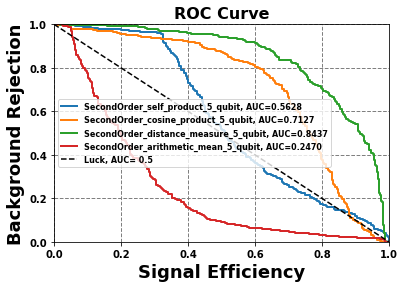

In [24]:
# plot the roc curves
fpr_list, tpr_list = [], []
for i,model in enumerate(my_models):
    y_score = vqc.predict(x_test_tensors[i])
    fpr, tpr, _ = roc_curve(y_test, y_score)
    fpr_list.append(fpr)
    tpr_list.append(tpr)
labels = ['SecondOrder_self_product_5_qubit',
          'SecondOrder_cosine_product_5_qubit',
          'SecondOrder_distance_measure_5_qubit',
          'SecondOrder_arithmetic_mean_5_qubit']
multi_model_plt = quple.utils.utils.plot_stacked_roc_curve(fpr_list, tpr_list, labels)

## The VQC Logger

The logger will save the following information:

The following will be saved to a log text file as well as a npz file
- Number of qubits
- Qubit layout
- Name of encoding circuit
- Name of encoding map
- Name of variational circuit
- Circuit parameters
- Number of parameters
- Name of Optimizer
- Name of Loss Function
- Name of Activation Function
- Name of Metrics
- Train Size
- Val Size
- Test Size
- Batch Size
- Number of Epochs
- Circuit Diagram for Encoding Circuit
- Circuit Diagram for Variational Circuit
- Losses in each epoch
- Model weights after training
- fpr for roc curve
- tpr for roc curve
- auc for roc curve

The following will be saved as a png file
- A ROC curve plot

In [13]:
from quple.classifiers.vqc_logger import VQCLogger
logger = VQCLogger()

In [14]:
# run the training, evaluation and test
vqc.run(x_train, y_train, x_val, y_val, x_test, y_test, batch_size=64, epochs=5, callbacks=[logger])

Converting circuits to tensors...
Converting circuits to tensors...
2021-03-29 21:51:59,362 [MainThread  ][INFO ]  ######## Executing VQC with the following attributes ########
2021-03-29 21:51:59,364 [MainThread  ][INFO ]  Feature Dimension: 5
2021-03-29 21:51:59,368 [MainThread  ][INFO ]  Number of Qubits: 5
2021-03-29 21:51:59,368 [MainThread  ][INFO ]  Qubit Layout: [cirq.GridQubit(0, 0), cirq.GridQubit(0, 1), cirq.GridQubit(0, 2), cirq.GridQubit(0, 3), cirq.GridQubit(0, 4)]
2021-03-29 21:51:59,370 [MainThread  ][INFO ]  Encoding Circuit: FirstOrderPauliZEncoding
2021-03-29 21:51:59,371 [MainThread  ][INFO ]  Encoding Map: self_product
2021-03-29 21:51:59,371 [MainThread  ][INFO ]  Variational Circuit: EfficientSU2
2021-03-29 21:51:59,372 [MainThread  ][INFO ]  Circuit Parameters: ['θ_0', 'θ_1', 'θ_2', 'θ_3', 'θ_4', 'θ_5', 'θ_6', 'θ_7', 'θ_8', 'θ_9', 'θ_10', 'θ_11', 'θ_12', 'θ_13', 'θ_14', 'θ_15', 'θ_16', 'θ_17', 'θ_18', 'θ_19', 'θ_20', 'θ_21', 'θ_22', 'θ_23', 'θ_24', 'θ_25', 'θ_26

Epoch 1/5
16/16 [==============================] - 8s 475ms/step - loss: 0.1709 - binary_accuracy: 0.7470 - q_auc: 0.8552 - val_loss: 0.1705 - val_binary_accuracy: 0.7600 - val_q_auc: 0.8493
Epoch 2/5
16/16 [==============================] - 8s 501ms/step - loss: 0.1687 - binary_accuracy: 0.7590 - q_auc: 0.8591 - val_loss: 0.1702 - val_binary_accuracy: 0.7510 - val_q_auc: 0.8487
Epoch 3/5
16/16 [==============================] - 6s 400ms/step - loss: 0.1680 - binary_accuracy: 0.7570 - q_auc: 0.8601 - val_loss: 0.1693 - val_binary_accuracy: 0.7550 - val_q_auc: 0.8485
Epoch 4/5
16/16 [==============================] - 4s 258ms/step - loss: 0.1688 - binary_accuracy: 0.7570 - q_auc: 0.8430 - val_loss: 0.1725 - val_binary_accuracy: 0.7680 - val_q_auc: 0.8473
Epoch 5/5
16/16 [==============================] - 4s 257ms/step - loss: 0.1670 - binary_accuracy: 0.7610 - q_auc: 0.8519 - val_loss: 0.1706 - val_binary_accuracy: 0.7540 - val_q_auc: 0.8489


2021-03-29 21:52:30,897 [MainThread  ][INFO ]  ######## Training Ends ########
2021-03-29 21:52:30,900 [MainThread  ][INFO ]  Model weights: 
[ 3.6724112   3.3819113   0.29536682  1.4807464   5.2757998   6.155753
  2.0306861   6.1649556   1.5752543  -0.20109639  4.9529443   0.05439759
  2.5480926   3.2798216   0.6580327   2.5700545   0.6585342   1.6024128
  0.4525902   1.4754452   4.981911    4.914955   -0.21737815  5.9777646
  4.2709217   0.26600927  3.001229   -0.03117213  0.9643037   5.441328
  4.885033    2.0866764   2.298286    4.591137    5.5142093 ]
Converting circuits to tensors...
2021-03-29 21:52:36,490 [MainThread  ][INFO ]  ######## Test Begins ########
2021-03-29 21:52:36,491 [MainThread  ][INFO ]  Number of samples for Testing: 1000
2021-03-29 21:52:36,492 [MainThread  ][INFO ]  Number of Epochs: 10
2021-03-29 21:52:36,492 [MainThread  ][INFO ]  Batch Size: 64


32/32 [==============================] - ETA: 0s - loss: 0.1629 - binary_accuracy: 0.7700 - q_auc: 0.8660

2021-03-29 21:52:37,921 [MainThread  ][INFO ]  ######## Test Ends ########


32/32 [==============================] - 1s 43ms/step - loss: 0.1629 - binary_accuracy: 0.7700 - q_auc: 0.8660


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [27]:
#Let's check what files we've got
!ls logs/*

logs/checkpoint
logs/FirstOrderPauliZEncoding_self_product_EfficientSU2_5_qubit_sigmoid_Adam_train_1000_val_1000_test_1000_epoch_10_batch_size_64_2021-03-28_10-17-45.log
logs/FirstOrderPauliZEncoding_self_product_EfficientSU2_5_qubit_sigmoid_Adam_train_1000_val_1000_test_1000_epoch_10_batch_size_64_2021-03-28_10-17-45_model_weights.data-00000-of-00001
logs/FirstOrderPauliZEncoding_self_product_EfficientSU2_5_qubit_sigmoid_Adam_train_1000_val_1000_test_1000_epoch_10_batch_size_64_2021-03-28_10-17-45_model_weights.index
logs/FirstOrderPauliZEncoding_self_product_EfficientSU2_5_qubit_sigmoid_Adam_train_1000_val_1000_test_1000_epoch_10_batch_size_64_2021-03-28_10-17-45.npz
logs/FirstOrderPauliZEncoding_self_product_EfficientSU2_5_qubit_sigmoid_Adam_train_1000_val_1000_test_1000_epoch_10_batch_size_64_2021-03-28_10-17-45_roc_curve.eps
logs/FirstOrderPauliZEncoding_self_product_EfficientSU2_5_qubit_sigmoid_Adam_train_1000_val_1000_test_1000_epoch_10_batch_size_64_2021-03-28_10-17-45_roc_curv

In [28]:
#print out the content of the log file
import glob
logfile = glob.glob('logs/*.log')[0]
print(open(logfile, 'r').read())

2021-03-28 10:17:57,608 [MainThread  ][INFO ]  ######## Executing VQC with the following attributes ########
2021-03-28 10:17:57,610 [MainThread  ][INFO ]  Feature Dimension: 5
2021-03-28 10:17:57,611 [MainThread  ][INFO ]  Number of Qubits: 5
2021-03-28 10:17:57,616 [MainThread  ][INFO ]  Qubit Layout: [cirq.GridQubit(0, 0), cirq.GridQubit(0, 1), cirq.GridQubit(0, 2), cirq.GridQubit(0, 3), cirq.GridQubit(0, 4)]
2021-03-28 10:17:57,618 [MainThread  ][INFO ]  Encoding Circuit: FirstOrderPauliZEncoding
2021-03-28 10:17:57,620 [MainThread  ][INFO ]  Encoding Map: self_product
2021-03-28 10:17:57,621 [MainThread  ][INFO ]  Variational Circuit: EfficientSU2
2021-03-28 10:17:57,623 [MainThread  ][INFO ]  Circuit Parameters: ['θ_0', 'θ_1', 'θ_2', 'θ_3', 'θ_4', 'θ_5', 'θ_6', 'θ_7', 'θ_8', 'θ_9', 'θ_10', 'θ_11', 'θ_12', 'θ_13', 'θ_14', 'θ_15', 'θ_16', 'θ_17', 'θ_18', 'θ_19', 'θ_20', 'θ_21', 'θ_22', 'θ_23', 'θ_24', 'θ_25', 'θ_26', 'θ_27', 'θ_28', 'θ_29', 'θ_30', 'θ_31', 'θ_32', 'θ_33', 'θ_34']
2

In [29]:
#print out content of the npz file
npzfile = glob.glob('logs/*.npz')[0]
print(dict(np.load(npzfile, allow_pickle=True)))

{'train_result': array([{'loss': 0.23917262256145477, 'binary_accuracy': 0.6290000081062317, 'auc': 0.6647066473960876, 'val_loss': 0.22700382769107819, 'val_binary_accuracy': 0.6639999747276306, 'val_auc': 0.8011172413825989, 'epoch': 0},
       {'loss': 0.22456234693527222, 'binary_accuracy': 0.6700000166893005, 'auc': 0.7902291417121887, 'val_loss': 0.21660162508487701, 'val_binary_accuracy': 0.7039999961853027, 'val_auc': 0.8237947821617126, 'epoch': 1},
       {'loss': 0.2149585336446762, 'binary_accuracy': 0.7070000171661377, 'auc': 0.8210192322731018, 'val_loss': 0.20805583894252777, 'val_binary_accuracy': 0.7210000157356262, 'val_auc': 0.8406798243522644, 'epoch': 2},
       {'loss': 0.2072983831167221, 'binary_accuracy': 0.7099999785423279, 'auc': 0.842509388923645, 'val_loss': 0.20246285200119019, 'val_binary_accuracy': 0.7350000143051147, 'val_auc': 0.8474462032318115, 'epoch': 3},
       {'loss': 0.2026492804288864, 'binary_accuracy': 0.7379999756813049, 'auc': 0.8515754342

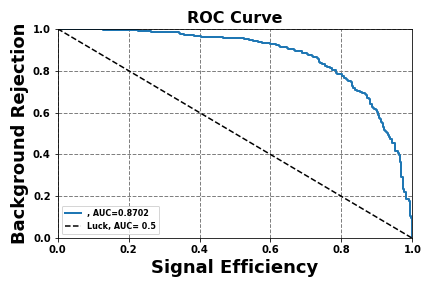

In [30]:
#display the roc curve
from IPython.display import Image
roc_image = glob.glob('logs/*.png')[0]
Image(filename=roc_image) 

In [31]:
# Now try customizing the loggers
# Let's say we want to save the log files in the directory my_logs
log_dir = 'my_logs'
# Let's say we want the file name format to be simply
filename = '{encoding_circuit}_{variational_circuit}_{n_qubit}_{time}'
# do not save npz file
save_npz = False
# do not save the model
save_weights = False
# do not save roc plot
roc_plot = False
# do not print logs unless fatal error messages
import logging
stream_level = logging.CRITICAL
# only save logs of level INFO or higher
file_level = logging.INFO
# only save the auc infos for the training results
keys = ['AUC', 'val_AUC', 'epoch']
logger = VQCLogger(log_dir=log_dir,filename=filename, keys=keys, stream_level=stream_level, file_level=file_level, save_npz=save_npz, save_weights=save_weights, roc_plot=roc_plot)

In [32]:
# Let's train again
vqc = VQC(encoding_circuit, variational_circuit, activation='sigmoid',
          optimizer=tf.keras.optimizers.Adam(), metrics=['binary_accuracy','qAUC'], loss='mse',
          readout=[variational_circuit.readout_measurement()], trainable_dense_layer=False)
vqc.run(x_train, y_train, x_val, y_val, x_test, y_test, batch_size=64, epochs=100, callbacks=[logger])

Registered encoding circuit with feature dimension: 5
Registered variational circuit with number of parameters: 35
Converting circuits to tensors...
Converting circuits to tensors...


Epoch 1/100
16/16 [==============================] - 2s 132ms/step - loss: 0.2460 - binary_accuracy: 0.6080 - auc: 0.6140 - val_loss: 0.2449 - val_binary_accuracy: 0.6270 - val_auc: 0.6416
Epoch 2/100
16/16 [==============================] - 2s 119ms/step - loss: 0.2445 - binary_accuracy: 0.6260 - auc: 0.6418 - val_loss: 0.2434 - val_binary_accuracy: 0.6330 - val_auc: 0.6672
Epoch 3/100
16/16 [==============================] - 2s 125ms/step - loss: 0.2431 - binary_accuracy: 0.6370 - auc: 0.6640 - val_loss: 0.2419 - val_binary_accuracy: 0.6510 - val_auc: 0.6864
Epoch 4/100
16/16 [==============================] - 2s 137ms/step - loss: 0.2415 - binary_accuracy: 0.6390 - auc: 0.6846 - val_loss: 0.2403 - val_binary_accuracy: 0.6630 - val_auc: 0.7025
Epoch 5/100
16/16 [==============================] - 2s 128ms/step - loss: 0.2400 - binary_accuracy: 0.6450 - auc: 0.7011 - val_loss: 0.2389 - val_binary_accuracy: 0.6740 - val_auc: 0.7142
Epoch 6/100
16/16 [==============================] - 2s

Converting circuits to tensors...


32/32 [==============================] - 1s 27ms/step - loss: 0.1951 - binary_accuracy: 0.7500 - auc: 0.8633
